In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

In [2]:
# importing packages
import os, sys
import pandas as pd
import numpy as np
import warnings

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d
from src import class_Harness as h

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, make_scorer)
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import (BaggingClassifier, AdaBoostClassifier,
                              RandomForestClassifier)
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
%matplotlib inline

sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette("winter_r")
pd.options.display.max_rows = 300

time: 1.42 s


## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 1.26 ms


**Run The Cell Below Once And Then Comment Out**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 414 µs


### Database ERD

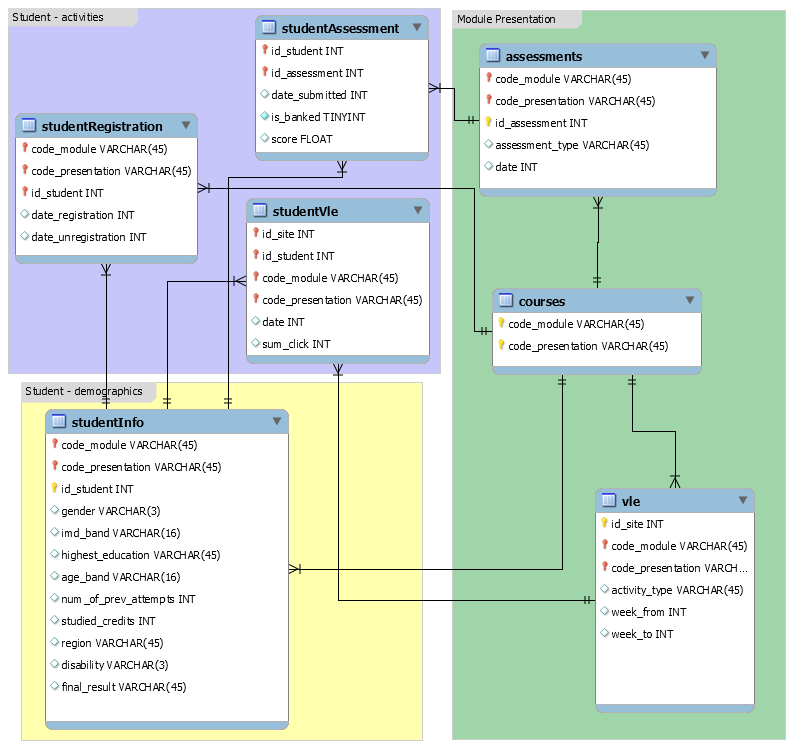

time: 3.41 ms


In [5]:
db.erd

## Preprocessing and Harness Objects

In [6]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ohe = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector))

preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
preprocessing_mm = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (MinMaxScaler(), number_selector))
sm = SMOTE(random_state=2021)

time: 1 ms


In [7]:
# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('f1', 'recall', 'precision'))

time: 2.69 ms


# STUDENTINFO Table

In [8]:
db.table_info('STUDENTINFO')

[(0, 'code_module', 'TEXT', 0, None, 0),
 (1, 'code_presentation', 'TEXT', 0, None, 0),
 (2, 'id_student', 'TEXT', 0, None, 0),
 (3, 'gender', 'TEXT', 0, None, 0),
 (4, 'region', 'TEXT', 0, None, 0),
 (5, 'highest_education', 'TEXT', 0, None, 0),
 (6, 'imd_band', 'TEXT', 0, None, 0),
 (7, 'age_band', 'TEXT', 0, None, 0),
 (8, 'num_of_prev_attempts', 'TEXT', 0, None, 0),
 (9, 'studied_credits', 'TEXT', 0, None, 0),
 (10, 'disability', 'TEXT', 0, None, 0),
 (11, 'final_result', 'TEXT', 0, None, 0)]

time: 3.27 ms


## Creating STUDENTINFO Data Frame

In [9]:
df = db.student_info()

time: 4.97 s


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31482 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                31482 non-null  int64   
 1   code_module           31482 non-null  object  
 2   code_presentation     31482 non-null  object  
 3   id_student            31482 non-null  object  
 4   gender                31482 non-null  object  
 5   region                31482 non-null  object  
 6   highest_education     31482 non-null  object  
 7   imd_band              31482 non-null  object  
 8   age_band              31482 non-null  object  
 9   num_of_prev_attempts  31482 non-null  object  
 10  disability            31482 non-null  object  
 11  course_load           31482 non-null  category
dtypes: category(1), int64(1), object(10)
memory usage: 2.9+ MB
time: 22.9 ms


In [11]:
df.target.value_counts(normalize=True)

0    0.534496
1    0.465504
Name: target, dtype: float64

time: 4.68 ms


## Creating Holdout Data

In [12]:
X, y = f.X_y(df)

time: 3.84 ms


In [13]:
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 15.4 ms


## Creating Training Data

In [14]:
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 12.6 ms


## Baseline Model: Dummy Classifier

In [15]:
dummy = DummyClassifier(strategy='most_frequent')

time: 547 µs


In [16]:
baseline = make_pipeline(preprocessing_ohe, dummy)

time: 1.03 ms


### Fitting Model

In [17]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfc70>)])),
                ('dummyclassifier', DummyClassifier(strategy='most_frequent'))])

time: 161 ms


### Saving Model

In [18]:
# f.pickle_model(baseline, 'baseline')

time: 527 µs


### Cross Val Scores

In [19]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    modeling.report(baseline, X_train, y_train, ' Baseline', 'Dummy')

 Baseline has an average F1 of 0.0
 Baseline has an average Recall of 0.0
 Baseline has an average Precision of 0.0
time: 600 ms


### Test Data Confusion Matrix

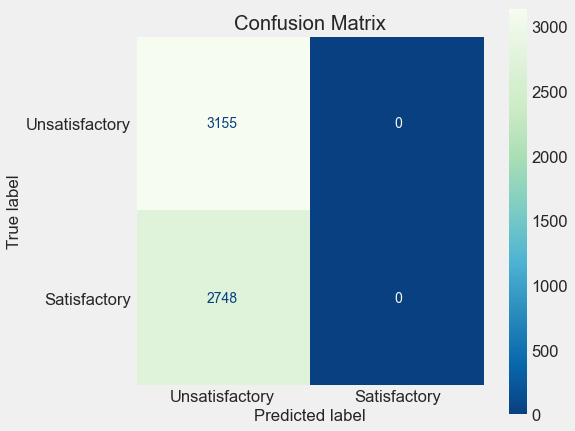

,F1,Recall,Precision
0,0.0,0.0,0.0


time: 369 ms


In [20]:
%%capture --no-display
f.confusion_report(baseline, X_test, y_test)

## First Simple Model: Naive Bayes Classifier

In [21]:
mnb = MultinomialNB()

time: 594 µs


In [22]:
fsm = make_pipeline(preprocessing_ohe, mnb)

time: 661 µs


### Fitting Model

In [23]:
fsm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfc70>)])),
                ('multinomialnb', MultinomialNB())])

time: 128 ms


### Saving Model

In [24]:
# f.pickle_model(fsm, 'fsm')

time: 435 µs


### Cross Val Scores

In [25]:
# checking cross val scores
modeling.report(fsm, X_train, y_train, ' fsm', 'Naive Bayes')

 fsm has an average F1 of 0.4943672264162995
 fsm has an average Recall of 0.40980367624980135
 fsm has an average Precision of 0.6235759589938843


[0.4943672264162995, 0.40980367624980135, 0.6235759589938843]

time: 626 ms


### Test Data Confusion Matrix

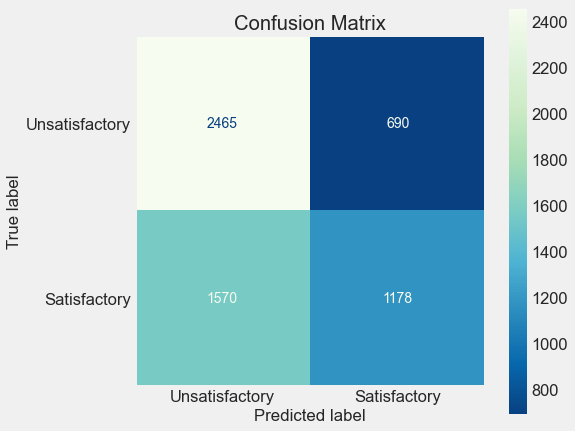

,F1,Recall,Precision
0,0.510399,0.428675,0.630621


time: 325 ms


In [26]:
f.confusion_report(fsm, X_test, y_test)

## KNeighborsClassifier

In [27]:
KNN = KNeighborsClassifier(n_jobs=-1)

time: 590 µs


In [28]:
knn = make_pipeline(preprocessing_ohe, KNN)

time: 947 µs


### Fitting Model

In [29]:
knn.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfc70>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 134 ms


In [30]:
# f.pickle_model(knn, 'knn')

time: 447 µs


### Cross Val Scores

In [31]:
# checking cross val scores
modeling.report(knn, X_train, y_train, 'knn', 'KNN')

knn has an average F1 of 0.5230115099742918
knn has an average Recall of 0.5106154362455622
knn has an average Precision of 0.5360632442523018


[0.5230115099742918, 0.5106154362455622, 0.5360632442523018]

time: 8.75 s


### Test Data Confusion Matrix

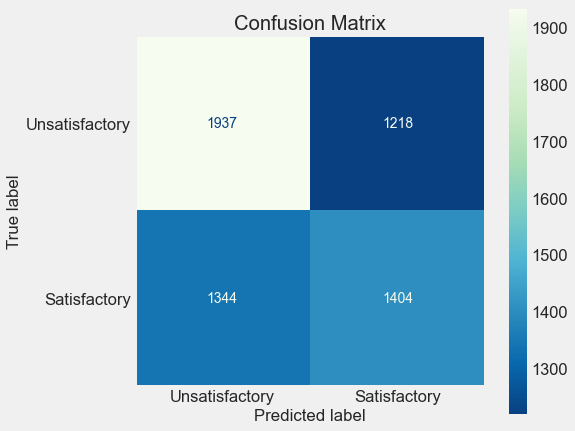

,F1,Recall,Precision
0,0.522905,0.510917,0.535469


time: 15.4 s


In [32]:
f.confusion_report(knn, X_test, y_test)

## Logistic Regression Classifier

In [33]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=2)

time: 609 µs


In [34]:
logreg = make_pipeline(preprocessing_ohe, LR)

time: 718 µs


### Fitting Model

In [35]:
logreg.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.2s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfc70>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

time: 4.51 s


In [36]:
# f.pickle_model(logreg, 'logreg')

time: 542 µs


### Cross Val Scores

In [37]:
# checking cross val scores
modeling.report(logreg, X_train, y_train, 'logreg', 'Logistic Regression')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


logreg has an average F1 of 0.5636097570237412
logreg has an average Recall of 0.5267501781014678
logreg has an average Precision of 0.6062986158636052


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s finished


[0.5636097570237412, 0.5267501781014678, 0.6062986158636052]

time: 11.8 s


### Test Data Confusion Matrix

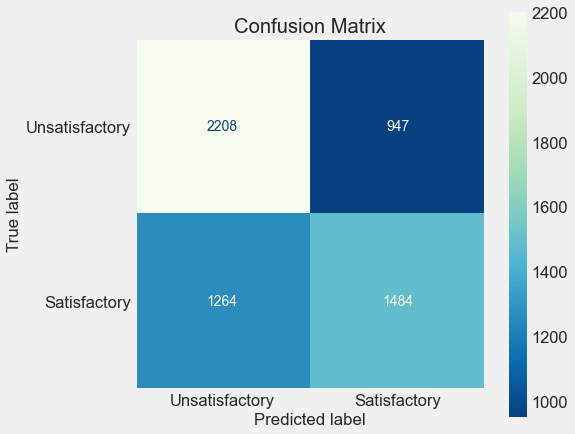

,F1,Recall,Precision
0,0.573084,0.540029,0.610448


time: 334 ms


In [38]:
f.confusion_report(logreg, X_test, y_test)

## Support Vector Machine

In [39]:
SVC = SVC()

time: 606 µs


In [40]:
svc = make_pipeline(preprocessing_ohe, SVC)

time: 683 µs


### Fitting Model

In [41]:
svc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfc70>)])),
                ('svc', SVC())])

time: 28 s


In [42]:
# f.pickle_model(svc, 'svc')

time: 463 µs


### Cross Val Scores

In [43]:
# checking cross val scores
modeling.report(svc, X_train, y_train, 'svc', 'Support Vector Classifier')

svc has an average F1 of 0.5640963271550907
svc has an average Recall of 0.5383963213951379
svc has an average Precision of 0.5928800521709763


[0.5640963271550907, 0.5383963213951379, 0.5928800521709763]

time: 1min 35s


### Test Data Confusion Matrix

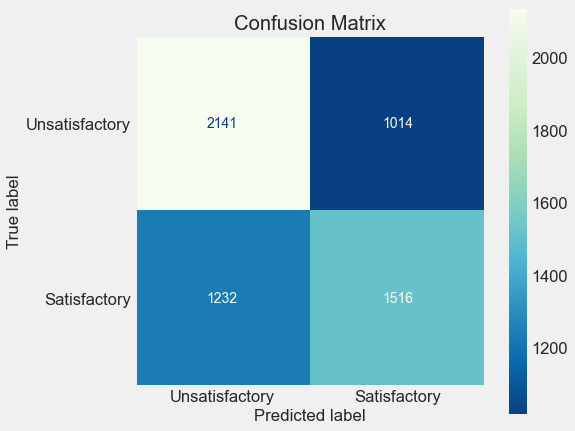

,F1,Recall,Precision
0,0.57446,0.551674,0.599209


time: 25.9 s


In [44]:
f.confusion_report(svc, X_test, y_test)

## Linear Support Vector Machine

In [45]:
LSVC = LinearSVC()

time: 771 µs


In [46]:
lsvc = make_pipeline(preprocessing_ohe, LSVC)

time: 860 µs


### Fitting Model

In [47]:
lsvc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfc70>)])),
                ('linearsvc', LinearSVC())])

time: 562 ms


In [48]:
# f.pickle_model(lsvc, 'lsvc')

time: 495 µs


### Cross Val Scores

In [49]:
# checking cross val scores
modeling.report(lsvc, X_train, y_train, 'lsvc', 'Linear SVC')

lsvc has an average F1 of 0.5638467676321548
lsvc has an average Recall of 0.5348780814497754
lsvc has an average Precision of 0.5962876632286748


[0.5638467676321548, 0.5348780814497754, 0.5962876632286748]

time: 1.88 s


### Test Data Confusion Matrix

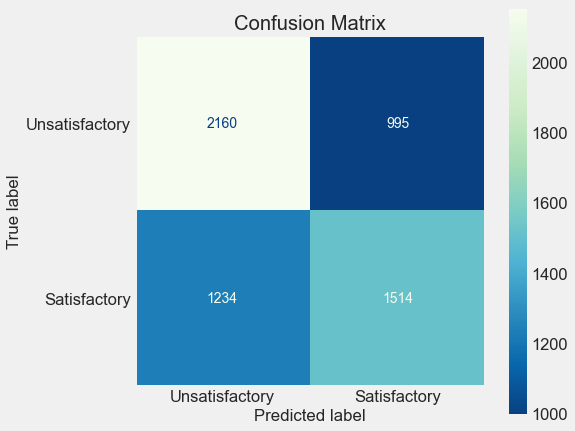

,F1,Recall,Precision
0,0.575994,0.550946,0.603428


time: 374 ms


In [50]:
f.confusion_report(lsvc, X_test, y_test)

## Decision Tree

In [51]:
DT = DecisionTreeClassifier(random_state=2021)

time: 687 µs


In [52]:
dt = make_pipeline(preprocessing_ohe, DT)

time: 740 µs


### Fitting Model

In [53]:
dt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfc70>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 1.72 s


In [54]:
# f.pickle_model(dt, 'dt')

time: 466 µs


### Cross Val Scores

In [55]:
# checking cross val scores
modeling.report(dt, X_train, y_train, 'dt', 'Decision Tree')

dt has an average F1 of 0.5314125705008425
dt has an average Recall of 0.5197133302325033
dt has an average Precision of 0.5436797603373874


[0.5314125705008425, 0.5197133302325033, 0.5436797603373874]

time: 5.72 s


### Test Data Confusion Matrix

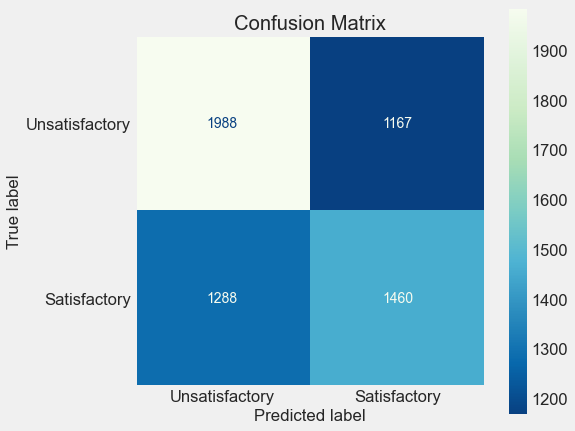

,F1,Recall,Precision
0,0.543256,0.531295,0.555767


time: 407 ms


In [56]:
f.confusion_report(dt, X_test, y_test)

## Bagging Classifier

In [57]:
BCLF = BaggingClassifier(base_estimator=DT, random_state=2021)

time: 651 µs


In [58]:
bclf = make_pipeline(preprocessing_ohe, BCLF)

time: 723 µs


### Fitting Model

In [59]:
bclf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfc70>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 13.6 s


In [60]:
# f.pickle_model(bclf, 'bclf')

time: 437 µs


### Cross Val Scores

In [61]:
# checking cross val scores
modeling.report(bclf, X_train, y_train, 'bclf', 'Bagging CLF')

bclf has an average F1 of 0.5436817368701766
bclf has an average Recall of 0.5085510783234322
bclf has an average Precision of 0.5842431774790179


[0.5436817368701766, 0.5085510783234322, 0.5842431774790179]

time: 46.7 s


### Test Data Confusion Matrix

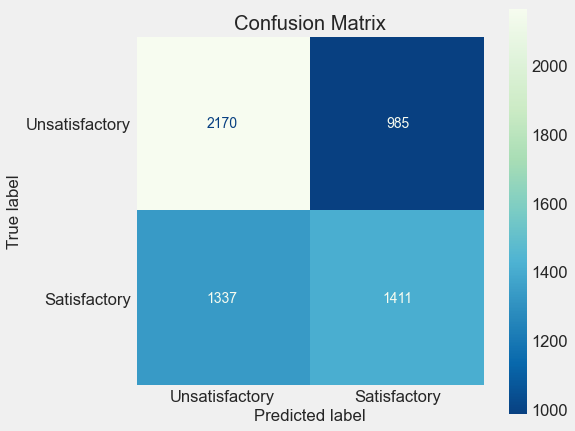

,F1,Recall,Precision
0,0.5486,0.513464,0.588898


time: 465 ms


In [62]:
f.confusion_report(bclf, X_test, y_test)

## Random Forest Classifier

In [63]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

time: 638 µs


In [64]:
rf = make_pipeline(preprocessing_ohe, RF)

time: 754 µs


### Fitting Model

In [65]:
rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfc70>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 12.9 s


In [66]:
# f.pickle_model(rf, 'rf')

time: 523 µs


### Cross Val Scores

In [67]:
# checking cross val scores
modeling.report(rf, X_train, y_train, 'rf', 'Random Forest')

rf has an average F1 of 0.5273247121092245
rf has an average Recall of 0.4916909041666912
rf has an average Precision of 0.5686083712855169


[0.5273247121092245, 0.4916909041666912, 0.5686083712855169]

time: 49 s


### Test Data Confusion Matrix

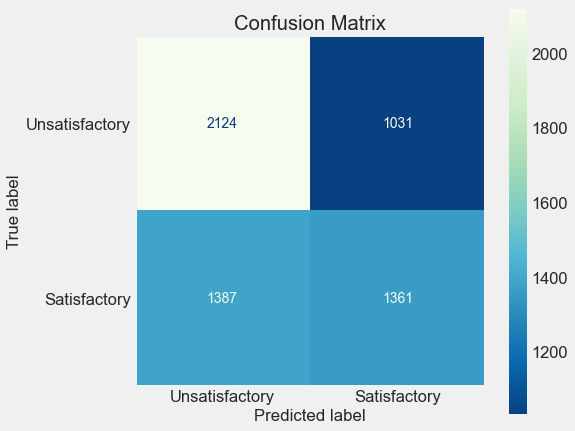

,F1,Recall,Precision
0,0.529572,0.495269,0.56898


time: 882 ms


In [68]:
f.confusion_report(rf, X_test, y_test)

## AdaBoost

In [69]:
ADA = AdaBoostClassifier(base_estimator=DT, random_state=2021)

time: 717 µs


In [70]:
ada = make_pipeline(preprocessing_ohe, ADA)

time: 935 µs


### Fitting Model

In [71]:
ada.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfc70>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 1.83 s


In [72]:
# f.pickle_model(ada, 'ada')

time: 547 µs


### Cross Val Scores

In [73]:
# checking cross val scores
modeling.report(ada, X_train, y_train, 'ada', 'AdaBoost')

ada has an average F1 of 0.5286066569890219
ada has an average Recall of 0.515828951939098
ada has an average Precision of 0.5421584886695583


[0.5286066569890219, 0.515828951939098, 0.5421584886695583]

time: 5.99 s


### Test Data Confusion Matrix

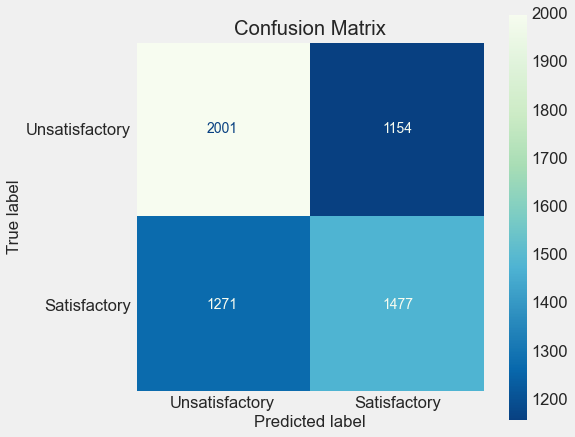

,F1,Recall,Precision
0,0.549173,0.537482,0.561384


time: 360 ms


In [74]:
f.confusion_report(ada, X_test, y_test)

## XGBoost

In [75]:
XGB = XGBClassifier(use_label_encoder=False)

time: 752 µs


In [76]:
xgb = make_pipeline(preprocessing_ohe, XGB)

time: 683 µs


### Fitting Model

In [77]:
%%capture --no-display
xgb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfc70>)])),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               impo...pe='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
            

time: 3.8 s


In [78]:
# f.pickle_model(xgb, 'xgb')

time: 825 µs


### Cross Val Scores

In [79]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb, X_train, y_train, 'xgb', 'XGBoost')

[0.542734555699536, 0.5239571496699971, 0.5632411485058106]

time: 17.5 s


### Test Data Confusion Matrix

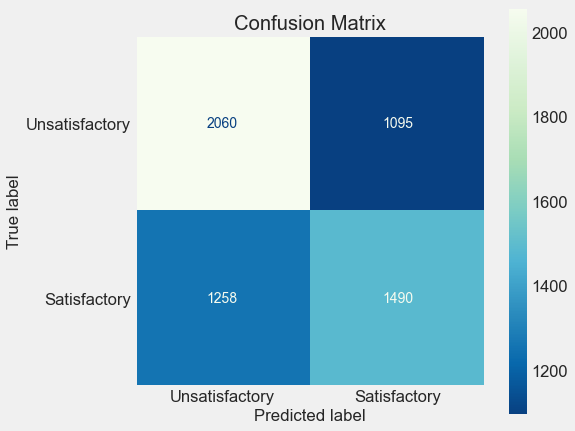

,F1,Recall,Precision
0,0.558785,0.542213,0.576402


time: 760 ms


In [80]:
%%capture --no-display
f.confusion_report(xgb, X_test, y_test)

In [81]:
modeling.history

,Name,F1,Recall,Precision,Notes
0,Baseline,0.000000,0.000000,0.000000,Dummy
1,fsm,0.494367,0.409804,0.623576,Naive Bayes
2,knn,0.523012,0.510615,0.536063,KNN
3,rf,0.527325,0.491691,0.568608,Random Forest
4,ada,0.528607,0.515829,0.542158,AdaBoost
5,dt,0.531413,0.519713,0.543680,Decision Tree
10,xgb,0.542735,0.523957,0.563241,XGBoost
6,bclf,0.543682,0.508551,0.584243,Bagging CLF
7,logreg,0.563610,0.526750,0.606299,Logistic Regression
8,lsvc,0.563847,0.534878,0.596288,Linear SVC


time: 9.19 ms


# STUDENTINFO & STUDENTVLE

In [82]:
df = db.sv_si()

time: 41.8 s


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28174 entries, 0 to 29227
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                28174 non-null  int64   
 1   code_module           28174 non-null  object  
 2   code_presentation     28174 non-null  object  
 3   id_student            28174 non-null  object  
 4   id_site               28174 non-null  object  
 5   date                  28174 non-null  int64   
 6   click_sum             28174 non-null  int64   
 7   gender                28174 non-null  object  
 8   region                28174 non-null  object  
 9   highest_education     28174 non-null  object  
 10  imd_band              28174 non-null  object  
 11  age_band              28174 non-null  object  
 12  num_of_prev_attempts  28174 non-null  int64   
 13  disability            28174 non-null  object  
 14  course_load           28174 non-null  category
dtypes:

In [84]:
df.head()

,target,code_module,code_presentation,id_student,id_site,date,click_sum,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,disability,course_load
0,1,AAA,2013J,100893,547013,-9,744,Male,Yorkshire Region,A Level or Equivalent,20-30%,0-35,0,No,Light
1,1,AAA,2013J,101781,546614,-10,4104,Male,South Region,Lower Than A Level,80-90%,35-55,0,No,Light
2,1,AAA,2013J,102806,546719,-10,1944,Male,North Western Region,A Level or Equivalent,30-40%,0-35,0,No,Light
3,1,AAA,2013J,102952,546879,-3,1150,Male,London Region,HE Qualification,60-70%,0-35,0,No,Light
4,1,AAA,2013J,1035023,546652,-10,1896,Female,London Region,Lower Than A Level,30-40%,35-55,0,No,Light


time: 16.3 ms


In [85]:
df.describe()

,target,date,click_sum,num_of_prev_attempts
count,28174.000000,28174.000000,28174.000000,28174.000000
mean,0.520054,-8.099205,1326.499219,0.160006
std,0.499607,13.146396,1713.634452,0.475827
min,0.000000,-25.000000,1.000000,0.000000
25%,0.000000,-17.000000,252.000000,0.000000
50%,1.000000,-10.000000,717.000000,0.000000
75%,1.000000,-3.000000,1722.000000,0.000000
max,1.000000,238.000000,24139.000000,6.000000


time: 25.8 ms


## Creating Holdout Data

In [86]:
X, y = f.X_y(df)

time: 9.24 ms


In [87]:
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 27 ms


## Creating Training Data

In [88]:
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 23.8 ms


## MinMax Scaling
Since we've added numerical columns to the data, we'll test some scaling in the pipeline. K-Nearest Neighbors in particular is sensitive to differences in feature scale, and scaling can also help speed up convergence is certain algorithms.

## Naive Bayes Classifier

In [89]:
mnb_svsi = make_pipeline(preprocessing_mm, mnb)

time: 884 µs


### Fitting Model

In [90]:
mnb_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfc70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfcd0>)])),
                ('multinomialnb', MultinomialNB())])

time: 180 ms


### Saving Model

In [91]:
# f.pickle_model(mnb_svsi, 'mnb_svsi')

time: 449 µs


### Cross Val Scores

In [92]:
# checking cross val scores
modeling.report(mnb_svsi, X_train, y_train, ' mnb_svsi', 'Naive Bayes SVSI/MinMax()')

 mnb_svsi has an average F1 of 0.6626865393440375
 mnb_svsi has an average Recall of 0.6982150111571002
 mnb_svsi has an average Precision of 0.6306428659140809


[0.6626865393440375, 0.6982150111571002, 0.6306428659140809]

time: 764 ms


### Test Data Confusion Matrix

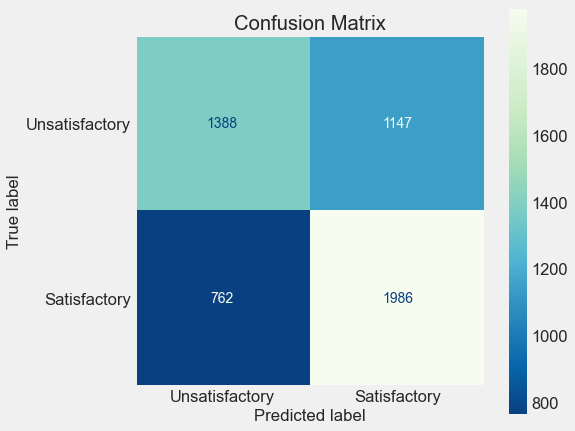

,F1,Recall,Precision
0,0.675395,0.722707,0.633897


time: 364 ms


In [93]:
f.confusion_report(mnb_svsi, X_test, y_test)

## KNeighborsClassifier

In [94]:
knn_svsi = make_pipeline(preprocessing_mm, KNN)

time: 674 µs


### Fitting Model

In [95]:
knn_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfc70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfcd0>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 151 ms


In [96]:
# f.pickle_model(knn_svsi, 'knn_svsi')

time: 435 µs


### Cross Val Scores

In [97]:
# checking cross val scores
modeling.report(knn_svsi, X_train, y_train, 'knn_svsi', 'KNN SVSI/MinMax()')

knn_svsi has an average F1 of 0.6974981774570128
knn_svsi has an average Recall of 0.7000365770369802
knn_svsi has an average Precision of 0.6949829323004745


[0.6974981774570128, 0.7000365770369802, 0.6949829323004745]

time: 9.35 s


### Test Data Confusion Matrix

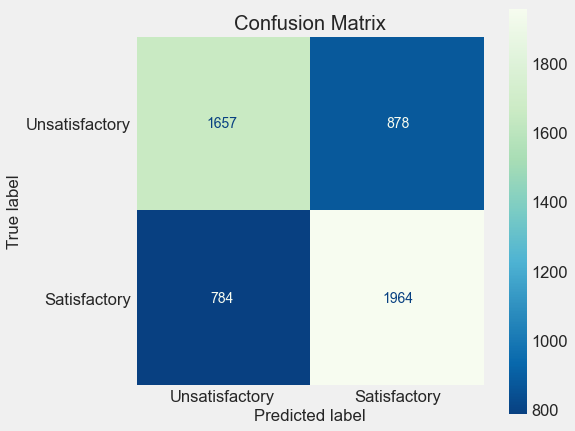

,F1,Recall,Precision
0,0.702683,0.714702,0.691063


time: 17.9 s


In [98]:
f.confusion_report(knn_svsi, X_test, y_test)

## Logistic Regression Classifier

In [99]:
logreg_svsi = make_pipeline(preprocessing_mm, LR)

time: 928 µs


### Fitting Model

In [100]:
logreg_svsi.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfc70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfcd0>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

time: 1.58 s


In [101]:
# f.pickle_model(logreg_svsi, 'logreg_svsi')

time: 563 µs


### Cross Val Scores

In [102]:
# checking cross val scores
modeling.report(logreg_svsi, X_train, y_train, 'logreg_svsi', 'LR SVSI/MinMax()')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


logreg_svsi has an average F1 of 0.7855241152551906
logreg_svsi has an average Recall of 0.776240969814009
logreg_svsi has an average Precision of 0.7950838311765471


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


[0.7855241152551906, 0.776240969814009, 0.7950838311765471]

time: 5.34 s


### Test Data Confusion Matrix

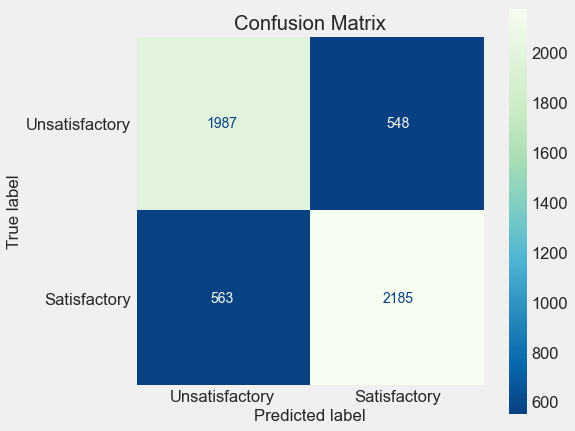

,F1,Recall,Precision
0,0.7973,0.795124,0.799488


time: 570 ms


In [103]:
f.confusion_report(logreg_svsi, X_test, y_test)

## Support Vector Machine

In [104]:
svc_svsi= make_pipeline(preprocessing_mm, SVC)

time: 968 µs


### Fitting Model

In [105]:
svc_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfc70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfcd0>)])),
                ('svc', SVC())])

time: 29.3 s


In [106]:
# f.pickle_model(svc, 'svc_svsi')

time: 548 µs


### Cross Val Scores

In [107]:
# checking cross val scores
modeling.report(svc_svsi, X_train, y_train, 'svc_svsi', 'SVC SVSI/MinMax()')

svc_svsi has an average F1 of 0.7405278616215177
svc_svsi has an average Recall of 0.7359540498213099
svc_svsi has an average Precision of 0.7452467032203173


[0.7405278616215177, 0.7359540498213099, 0.7452467032203173]

time: 1min 19s


### Test Data Confusion Matrix

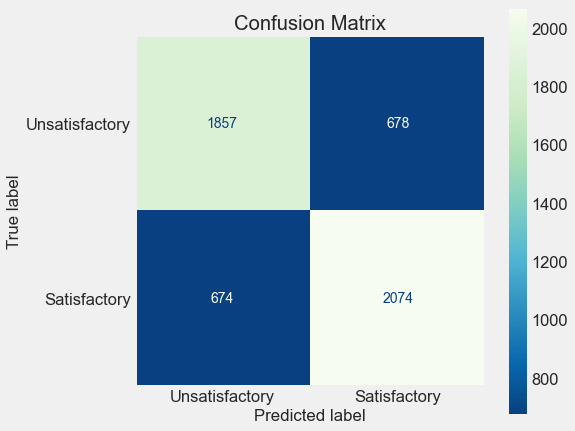

,F1,Recall,Precision
0,0.754182,0.754731,0.753634


time: 18.1 s


In [108]:
f.confusion_report(svc_svsi, X_test, y_test)

## Linear Support Vector Machine

In [109]:
lsvc_svsi = make_pipeline(preprocessing_mm, LSVC)

time: 652 µs


### Fitting Model

In [110]:
lsvc_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfc70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfcd0>)])),
                ('linearsvc', LinearSVC())])

time: 333 ms


In [111]:
# f.pickle_model(lsvc_svsi, 'lsvc_svsi')

time: 493 µs


### Cross Val Scores

In [112]:
# checking cross val scores
modeling.report(lsvc_svsi, X_train, y_train, 'lsvc_svsi', 'Linear SVC SVSI/MinMax()')

lsvc_svsi has an average F1 of 0.7839528103346464
lsvc_svsi has an average Recall of 0.7729645651674742
lsvc_svsi has an average Precision of 0.7952985179836267


[0.7839528103346464, 0.7729645651674742, 0.7952985179836267]

time: 1.44 s


### Test Data Confusion Matrix

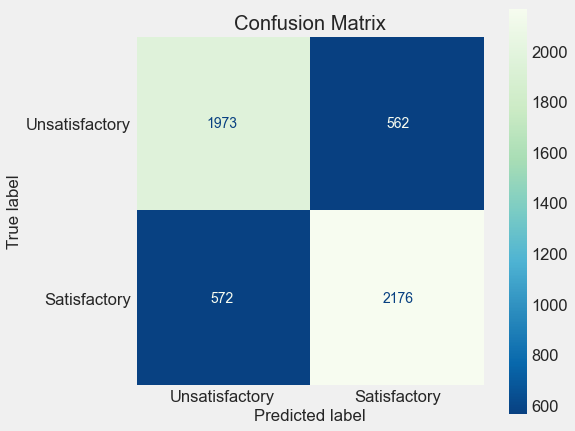

,F1,Recall,Precision
0,0.793292,0.791849,0.794741


time: 354 ms


In [113]:
f.confusion_report(lsvc_svsi, X_test, y_test)

## Decision Tree

In [114]:
dt_svsi = make_pipeline(preprocessing_mm, DT)

time: 710 µs


### Fitting Model

In [115]:
dt_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfc70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfcd0>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 1.08 s


In [116]:
# f.pickle_model(dt_svsi, 'dt_svsi')

time: 459 µs


### Cross Val Scores

In [117]:
# checking cross val scores
modeling.report(dt_svsi, X_train, y_train, 'dt_svsi', 'DT SVSI/MinMax()')

dt_svsi has an average F1 of 0.8042204691072193
dt_svsi has an average Recall of 0.8234443351957939
dt_svsi has an average Precision of 0.7858967293638646


[0.8042204691072193, 0.8234443351957939, 0.7858967293638646]

time: 4.23 s


### Test Data Confusion Matrix

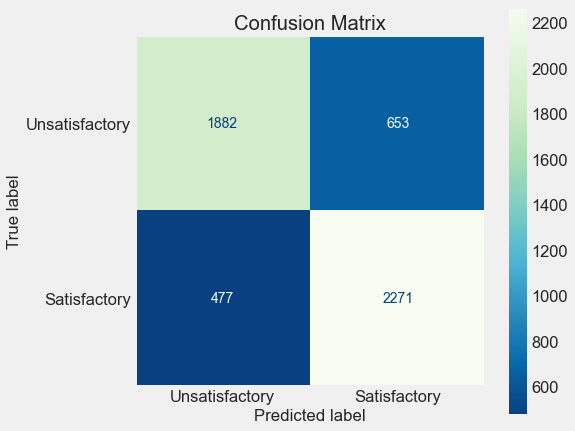

,F1,Recall,Precision
0,0.800776,0.826419,0.776676


time: 368 ms


In [118]:
f.confusion_report(dt_svsi, X_test, y_test)

## Bagging Classifier

In [119]:
bclf_svsi = make_pipeline(preprocessing_mm, BCLF)

time: 689 µs


### Fitting Model

In [120]:
bclf_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfc70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfcd0>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 7.81 s


In [121]:
# f.pickle_model(bclf_svsi, 'bclf_svsi')

time: 445 µs


### Cross Val Scores

In [122]:
# checking cross val scores
modeling.report(bclf_svsi, X_train, y_train, 'bclf_svsi', 'BCLF SVSI/MinMax()')

bclf_svsi has an average F1 of 0.829010145898202
bclf_svsi has an average Recall of 0.8528079683479838
bclf_svsi has an average Precision of 0.8065628291546962


[0.829010145898202, 0.8528079683479838, 0.8065628291546962]

time: 26.3 s


### Test Data Confusion Matrix

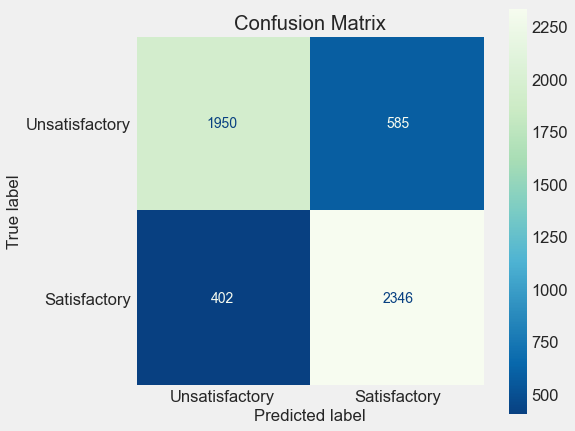

,F1,Recall,Precision
0,0.826202,0.853712,0.800409


time: 419 ms


In [123]:
f.confusion_report(bclf_svsi, X_test, y_test)

## Random Forest Classifier

In [124]:
rf_svsi = make_pipeline(preprocessing_mm, RF)

time: 662 µs


### Fitting Model

In [125]:
rf_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfc70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfcd0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 5.93 s


In [126]:
# f.pickle_model(rf_svsi, 'rf_svsi')

time: 408 µs


### Cross Val Scores

In [127]:
# checking cross val scores
modeling.report(rf_svsi, X_train, y_train, 'rf_svsi', 'RF SVSI/MinMax()')

rf_svsi has an average F1 of 0.8122074318841415
rf_svsi has an average Recall of 0.8401902153114273
rf_svsi has an average Precision of 0.7860628014442981


[0.8122074318841415, 0.8401902153114273, 0.7860628014442981]

time: 24 s


### Test Data Confusion Matrix

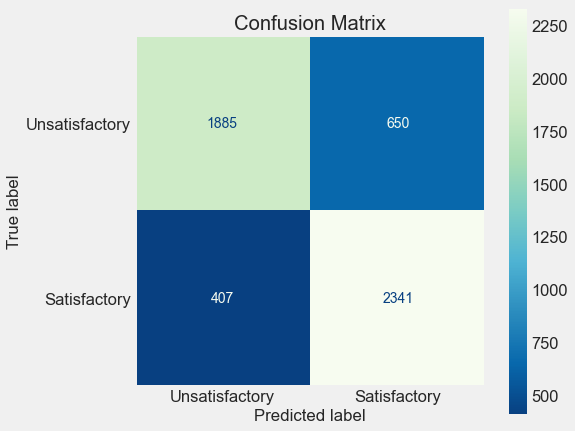

,F1,Recall,Precision
0,0.815822,0.851892,0.782681


time: 714 ms


In [128]:
f.confusion_report(rf_svsi, X_test, y_test)

## AdaBoost

In [129]:
ada_svsi = make_pipeline(preprocessing_mm, ADA)

time: 680 µs


### Fitting Model

In [130]:
ada_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfc70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfcd0>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 1.16 s


In [131]:
# f.pickle_model(ada_svsi, 'ada_svsi')

time: 439 µs


### Cross Val Scores

In [132]:
# checking cross val scores
modeling.report(ada_svsi, X_train, y_train, 'ada_svsi', 'ADA SVSI/MinMax()')

ada_svsi has an average F1 of 0.8051075289313424
ada_svsi has an average Recall of 0.8273273151718901
ada_svsi has an average Precision of 0.7840597140437353


[0.8051075289313424, 0.8273273151718901, 0.7840597140437353]

time: 4.86 s


### Test Data Confusion Matrix

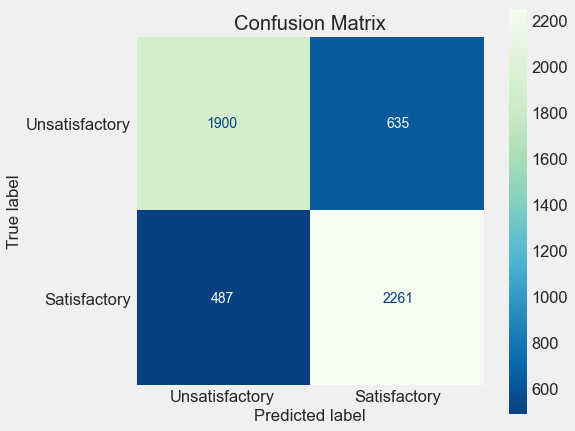

,F1,Recall,Precision
0,0.801205,0.82278,0.780732


time: 364 ms


In [133]:
f.confusion_report(ada_svsi, X_test, y_test)

## XGBoost

In [134]:
xgb_svsi = make_pipeline(preprocessing_mm, XGB)

time: 653 µs


### Fitting Model

In [135]:
%%capture --no-display
xgb_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfc70>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1601cfcd0>)])),
                ('xgbclassifier',
                 XGBClassifier(ba...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 3.77 s


In [136]:
# f.pickle_model(xgb_svsi, 'xgb_svsi')

time: 816 µs


### Cross Val Scores

In [137]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_svsi, X_train, y_train, 'xgb_svsi', 'XGB SVSI/MinMax()')

[0.835370315332517, 0.8722255912674347, 0.8015187031213997]

time: 15.5 s


### Test Data Confusion Matrix

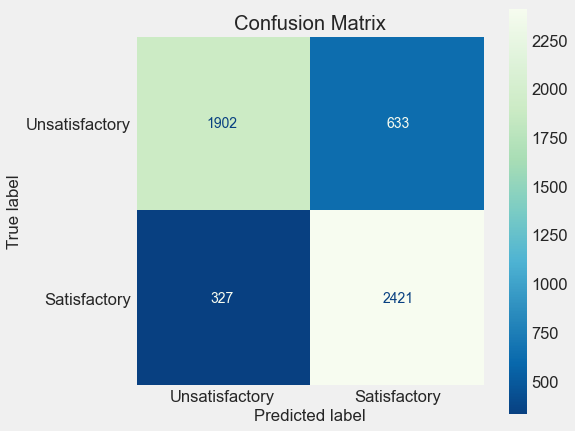

,F1,Recall,Precision
0,0.83454,0.881004,0.792731


time: 733 ms


In [138]:
%%capture --no-display
f.confusion_report(xgb_svsi, X_test, y_test)

In [139]:
modeling.history

,Name,F1,Recall,Precision,Notes
0,Baseline,0.000000,0.000000,0.000000,Dummy
1,fsm,0.494367,0.409804,0.623576,Naive Bayes
2,knn,0.523012,0.510615,0.536063,KNN
3,rf,0.527325,0.491691,0.568608,Random Forest
4,ada,0.528607,0.515829,0.542158,AdaBoost
5,dt,0.531413,0.519713,0.543680,Decision Tree
6,xgb,0.542735,0.523957,0.563241,XGBoost
7,bclf,0.543682,0.508551,0.584243,Bagging CLF
8,logreg,0.563610,0.526750,0.606299,Logistic Regression
9,lsvc,0.563847,0.534878,0.596288,Linear SVC


time: 10.4 ms
